In [1]:
"""
Test Script

"""
import random
import copy
import numpy as np
from vwgym import VacuumWorld, Vectorise, StepWrapper
from vwgym.fun_lite import *
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy.core.umath_tests import inner1d


random.seed(518123)

if torch.cuda.is_available():
    print('GPU Available:\t', True)
    device = 'cuda'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

else:
    device = 'cpu'

GPU Available:	 True


/home/archie/anaconda3/envs/hrl/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [2]:
# model_path = '/home/archie/Documents/RHUL/Term_01/CS5940-IA/HRL/vacuumworld-gym/vwgym/saved_model/f_net/trained_f_net/vwgym_fnet_1800_ckpt.pt'
model_path = '/home/archie/Documents/RHUL/Term_01/CS5940-IA/HRL/vacuumworld-gym/vwgym/vwgym_fnet_1600_ckpt.pt'

env, input_shape = make_env(grid_size=8, num_env=1, vectorize=True)
env = env[0]
env.state()

<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=3, y=1), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=6, y=4), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=7, y=4), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=4, y=6), agent=None, dirt=dirt(name='D-2', colour='orange'))


<class 'vacuumworld.vw.Grid'>: size: 8, agents: 1, dirts: 3, 
location(coordinate=coord(x=3, y=1), agent=agent(name='A-1', colour='white', orientation='east'), dirt=None)
location(coordinate=coord(x=6, y=4), agent=None, dirt=dirt(name='D-3', colour='green'))
location(coordinate=coord(x=7, y=4), agent=None, dirt=dirt(name='D-1', colour='orange'))
location(coordinate=coord(x=4, y=6), agent=None, dirt=dirt(name='D-2', colour='orange'))

In [3]:
checkpoint = torch.load(model_path)

In [4]:
args = checkpoint['args']

In [5]:
num_actions = env.action_space.n
f_net = FuNet(input_shape, args['d'],
              args['len_hist'],
              args['eps'],
              args['k'],
              num_actions,
              1, device)

In [6]:
f_net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [7]:
f_net

FuNet(
  (f_percept): Percept(
    (percept): Linear(in_features=132, out_features=256, bias=True)
  )
  (manager): Manager(
    (M_space): Linear(in_features=256, out_features=256, bias=True)
    (M_goals): Linear(in_features=256, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (M_value): Linear(in_features=512, out_features=1, bias=True)
  )
  (worker): Worker(
    (f_stateW): Linear(in_features=256, out_features=64, bias=True)
    (phi): Linear(in_features=256, out_features=16, bias=False)
    (wfc1): Linear(in_features=64, out_features=1024, bias=True)
    (wfc2): Linear(in_features=1024, out_features=512, bias=True)
    (W_value): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [8]:
goal_history = checkpoint['goal']
s_Mt_hist = checkpoint['man_state']

In [9]:
def take_action(action_probs):
    action = action_probs.max(1)[1]    
    return action.cpu().numpy()

def plot_goals(data):
    data = torch.stack(data).detach().sum(dim=0)
#     z = np.zeros((10, data.shape[1]))
#     for i in range(10):
#         z[i,:] = data   
    plt.figure(figsize=(18, 8))
    plt.imshow(z, cmap='gray');
    
# def plot_agent(vw, d1, d2, action, action_probs):  
# #     d1 = torch.stack(d1).detach().sum(dim=0).cpu().numpy().reshape(16, 16)
#     d1 = d1.detach().cpu().numpy().reshape(4, 4)
#     d2 = d2.detach().cpu().numpy().reshape(16, 16)
# #     mu = d2.mean()
# #     sd = d2.std()
# #     d2 = np.array([(i - mu)/sd for i in d2[0]]).reshape(16, 16)
    
    
#     action_meanings = ['move', 'clean', 'turn_left', 'turn_right']
#     orientation = ['north', 'east', 'south', 'west']
    
#     plt.figure(figsize=(22, 8))
    
#     plt.subplot(1, 6, 1)
#     plt.imshow(vw[:4].reshape(1, 4), cmap='gray')
#     plt.title(f'Orientation:  {orientation[np.argmax(vw[:4].reshape(1, 4))]}')

#     plt.subplot(1, 6, 2)
#     plt.imshow(vw[4:].reshape(2, 3, 3)[0], cmap='magma')
#     plt.title('Agent Location')

#     plt.subplot(1, 6, 3)
#     plt.imshow(vw[4:].reshape(2, 3, 3)[1], cmap='Oranges')
#     plt.title('Dirts')
    
    
#     plt.subplot(1, 6, 4)
# #     print(d1, d1.max())
#     plt.imshow(d1, cmap='binary')
#     plt.title('Phi(Goal-Sum)')
    
#     plt.subplot(1, 6, 5)
# #     m = d2 > d2.max() * 0.5
#     plt.imshow(d2, cmap='gray')
#     plt.title('Goal Generated')
    
#     plt.subplot(1, 6, 6)
#     plt.imshow(action_probs.detach().cpu().numpy().reshape(1, 4), cmap='gray')
#     plt.title(f'Action:  {action_meanings[action]}')
    
def plot_agent(vw, d2, action, action_probs):  
#     d1 = torch.stack(d1).detach().sum(dim=0).cpu().numpy().reshape(16, 16)
#     d1 = d1.detach().cpu().numpy().reshape(4, 4)
    d2 = d2.detach().cpu().numpy().reshape(16, 16)
#     mu = d2.mean()
#     sd = d2.std()
#     d2 = np.array([(i - mu)/sd for i in d2[0]]).reshape(16, 16)
    
    
    action_meanings = ['move', 'clean', 'turn_left', 'turn_right']
    orientation = ['north', 'east', 'south', 'west']
    
    plt.figure(figsize=(22, 8))
    
    plt.subplot(1, 5, 1)
    plt.imshow(vw[:4].reshape(1, 4), cmap='gray')
    plt.title(f'Orientation:  {orientation[np.argmax(vw[:4].reshape(1, 4))]}')

    plt.subplot(1, 5, 2)
    plt.imshow(vw[4:].reshape(2, 8, 8)[0], cmap='magma')
    plt.title('Agent Location')

    plt.subplot(1, 5, 3)
    plt.imshow(vw[4:].reshape(2, 8, 8)[1], cmap='Oranges')
    plt.title('Dirts')
    
    plt.subplot(1, 5, 4)
#     m = d2 > d2.max() * 0.5
    plt.imshow(d2, cmap='gray')
    plt.title('Goal Generated')
    
    plt.subplot(1, 5, 5)
    plt.imshow(action_probs.detach().cpu().numpy().reshape(1, 4), cmap='gray')
    plt.title(f'Action:  {action_meanings[action]}')

In [10]:
phi_g = torch.from_numpy(np.zeros([1, 16])).to(device)

In [11]:
prev = np.zeros(256)

In [12]:
z = goal_history[-1]
z = z.detach().cpu().numpy()[0]

In [13]:
def direction(prev, z):
#     return np.arccos(np.dot(prev/ np.sqrt(inner1d(prev,prev)), z/np.sqrt(inner1d(z,z))))
     return np.degrees(np.arccos(np.dot(prev/ np.sqrt(inner1d(prev,prev)), z/np.sqrt(inner1d(z,z)))))

# def direction(z):
#     return np.degrees(np.arctan(np.dot(z/ np.sqrt(inner1d(z,z)), z/np.sqrt(inner1d(z,z)))))

Dirts Present..:3

Grid Cleaned !!

{'ep_rewards': 283, 'ep_len': 21, 'move': 12, 'clean': 4, 'turn_left': 2, 'turn_right': 3}
Episode Rewards:	 283 
 ----------------------------------------


/home/archie/anaconda3/envs/hrl/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


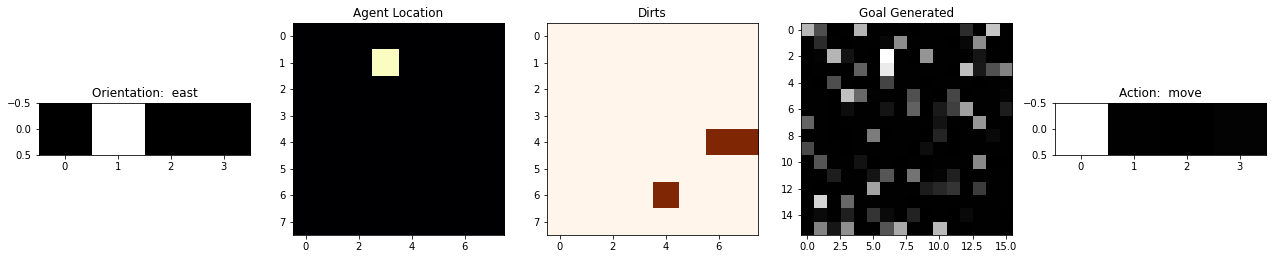

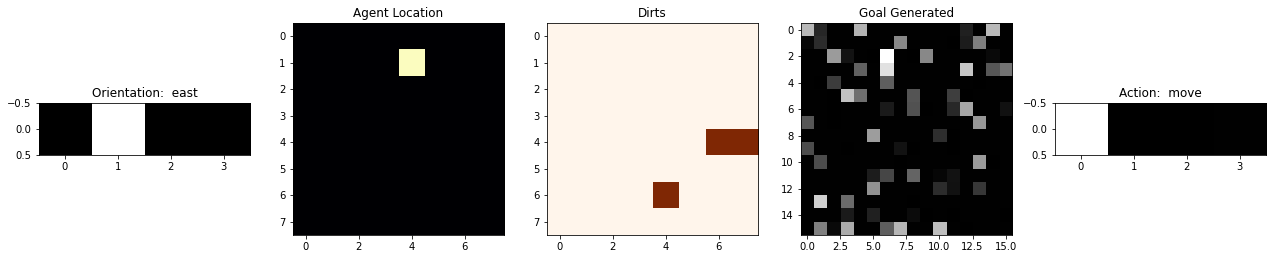

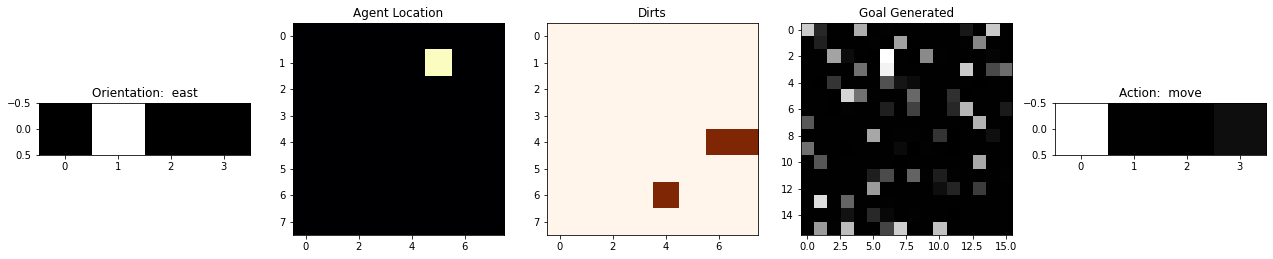

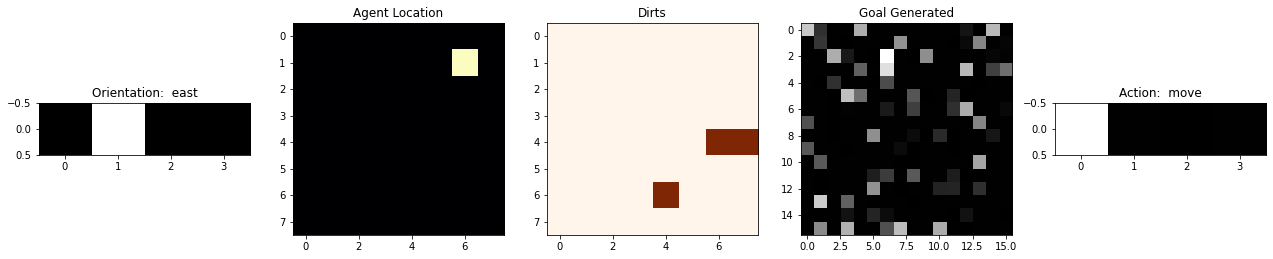

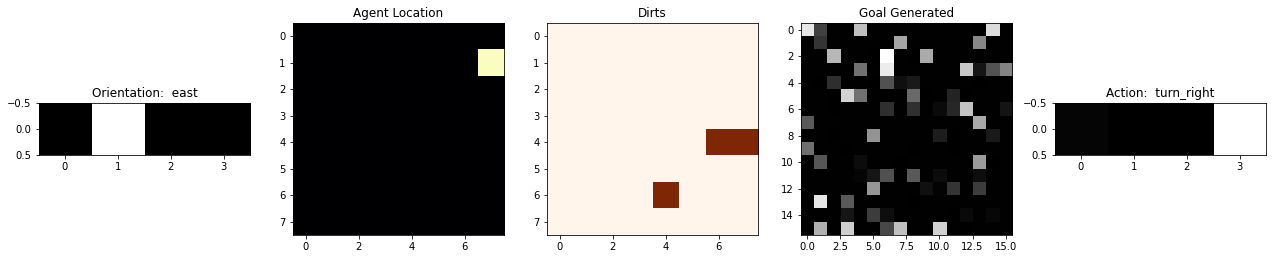

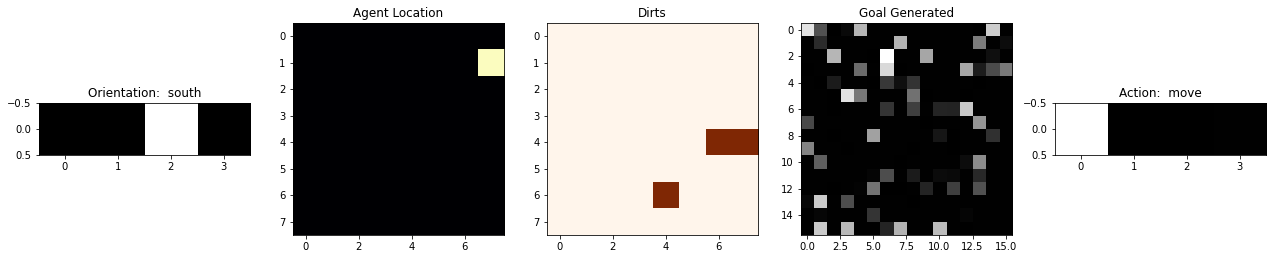

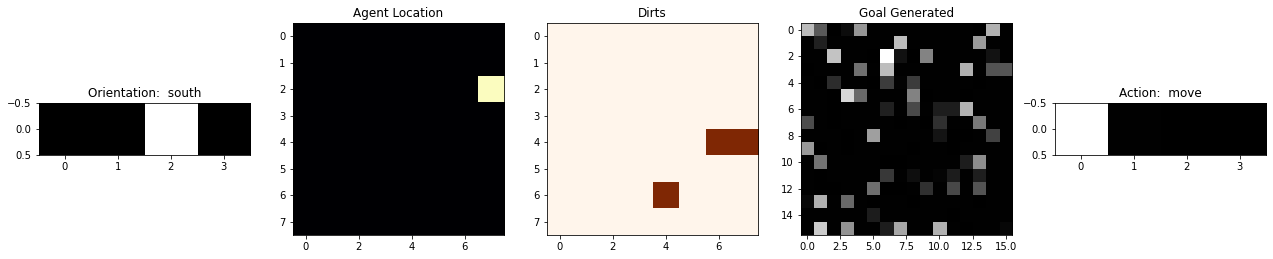

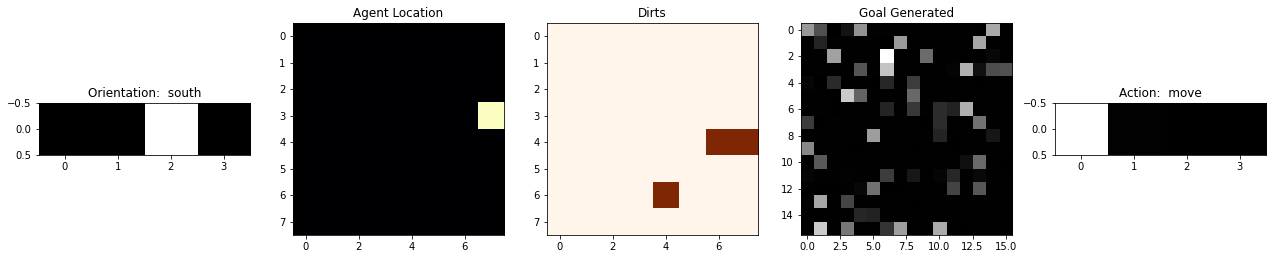

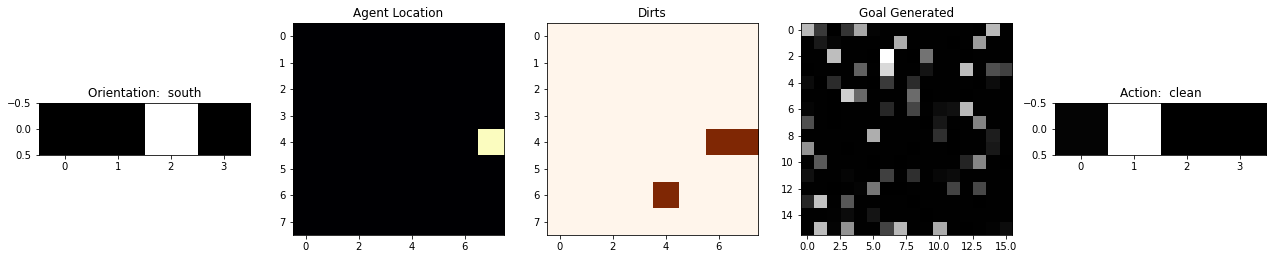

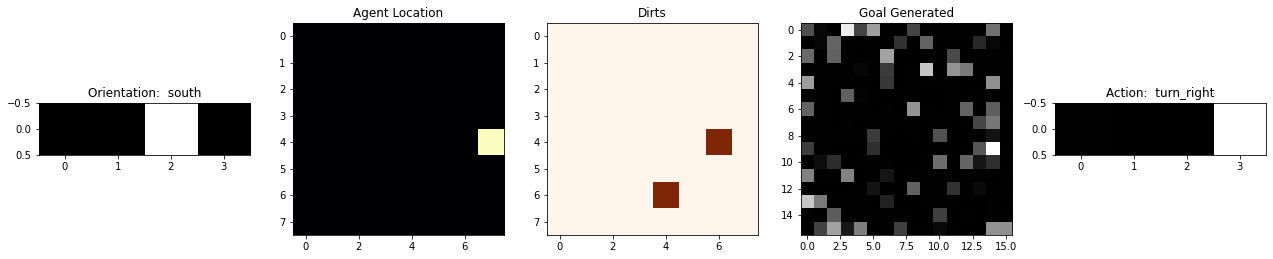

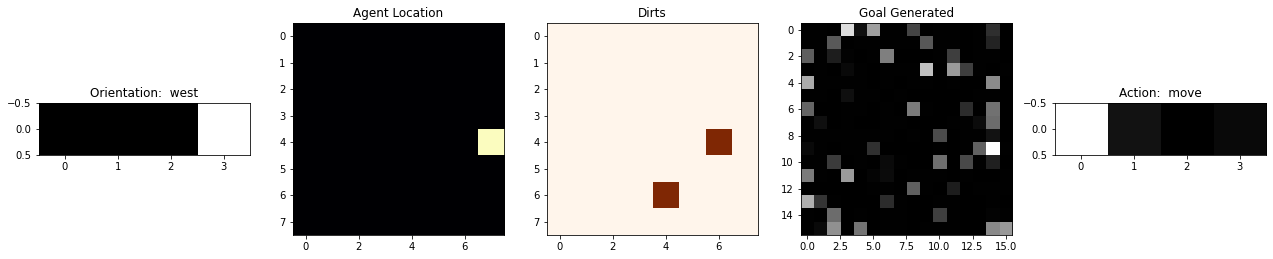

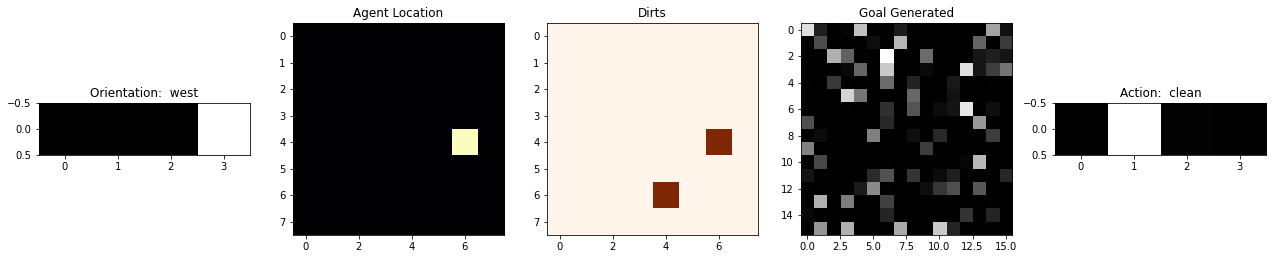

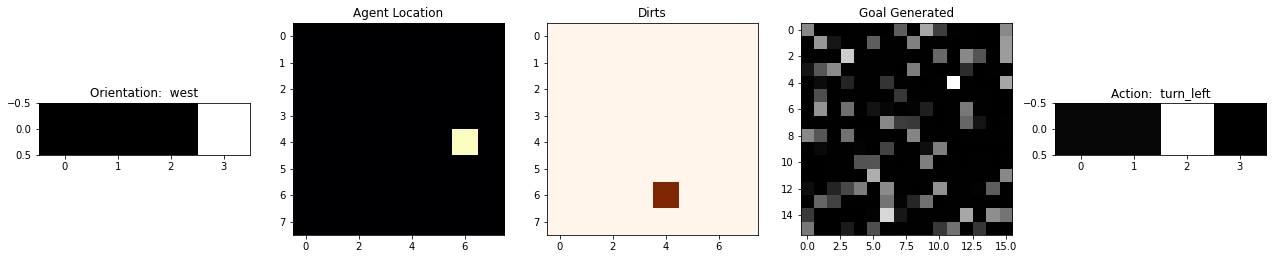

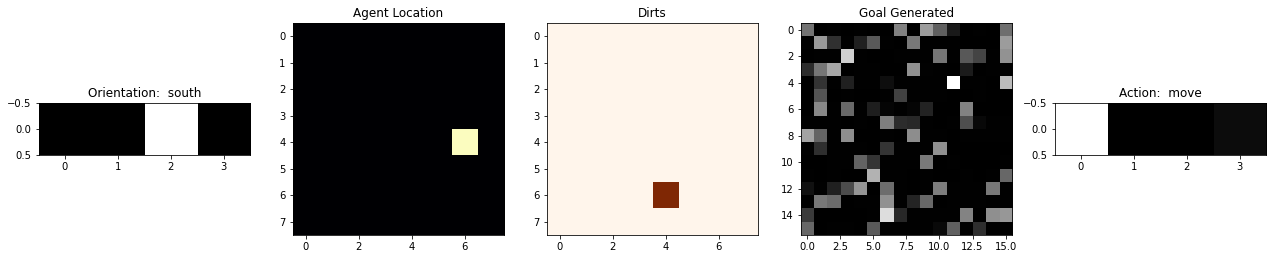

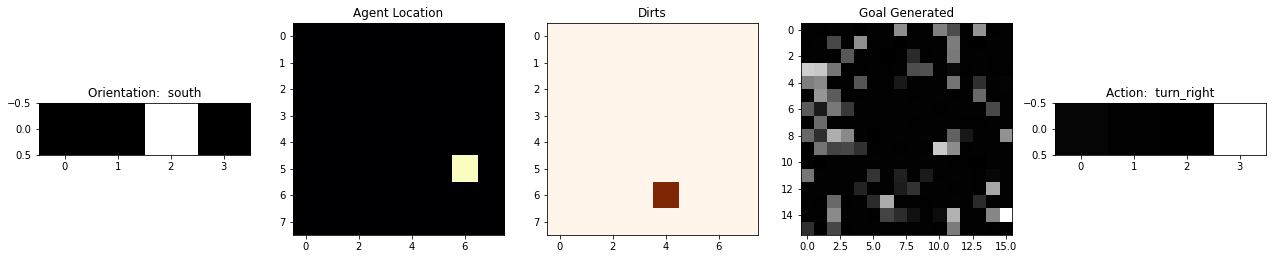

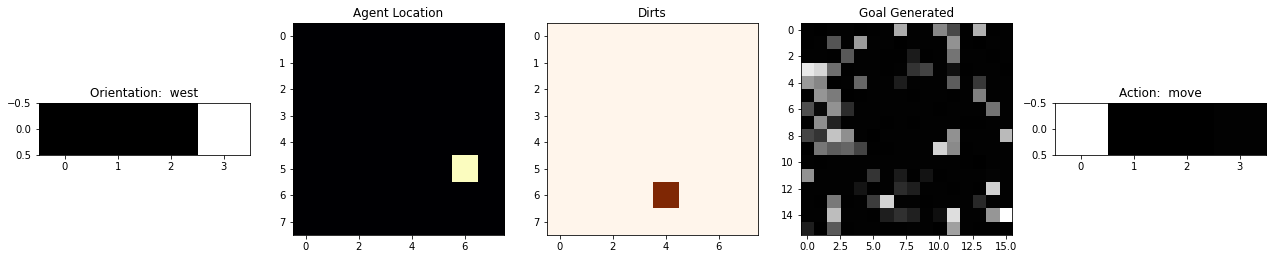

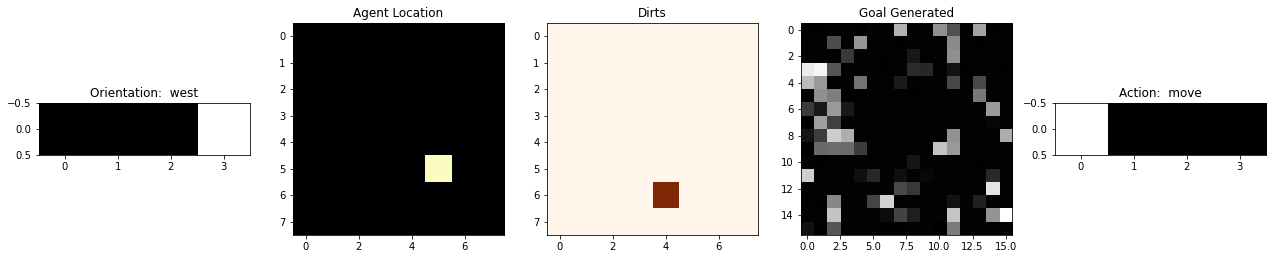

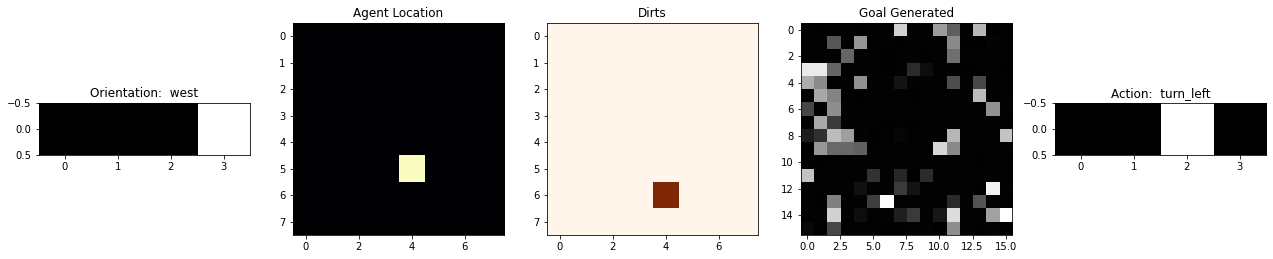

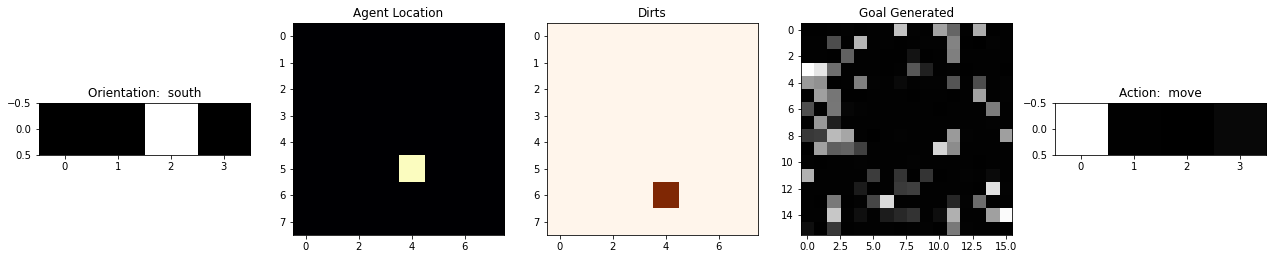

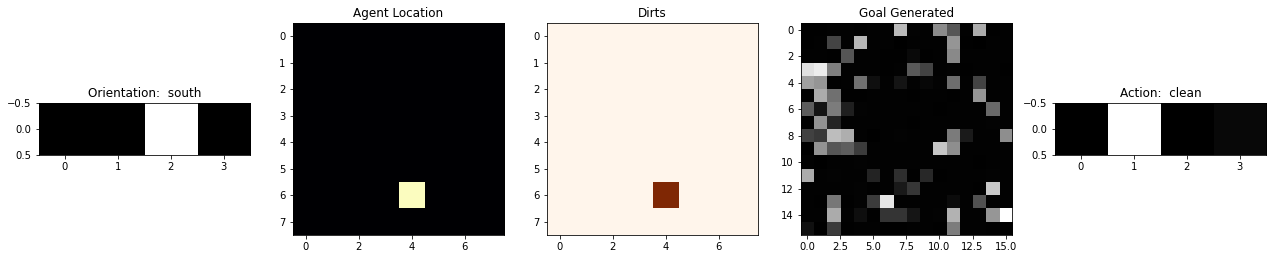

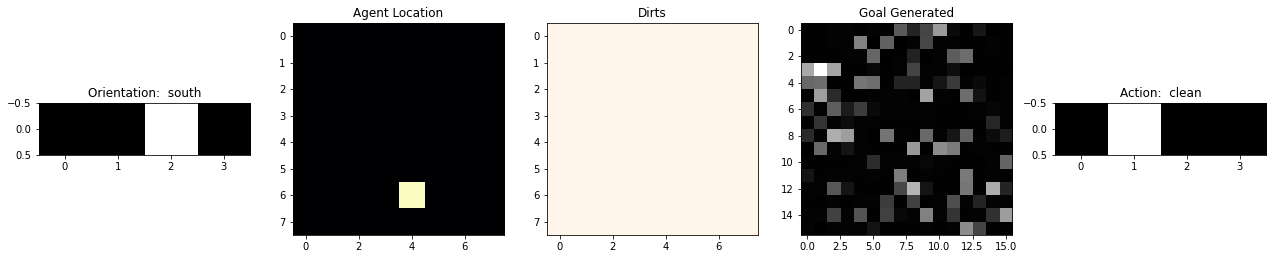

In [14]:
with torch.no_grad():

    f_net.eval()
    predictions = []
    goal_gen = []
    
#     goal_history, s_Mt_hist, ep_binary = f_net.agent_model_init()
    count = 0
    x = env.reset()
    env.rw_dirts = env.dirts
    print(f'Dirts Present..:{env.rw_dirts}')
    x_prev = x
    x = torch.from_numpy(x).float()
    x = x.view(1, -1).to(device)
    
    step = 0
    prev_action = []
    
    for __ in range(5000):
#         action_probs, _, _, goal_history, s_Mt_hist, phi_g  = f_net(x, goal_history, s_Mt_hist)
        action_probs, _, _, goal_history, s_Mt_hist  = f_net(x, goal_history, s_Mt_hist)
        
#         plot_goals(goal_history)
        a_t = take_action(action_probs)
        x, reward, done, ep_info = env.step(a_t[0])
        w = goal_history[:10]
#         w = w.detach().cpu().numpy()[0]
        goal_gen.append(w)
#         print(direction(w), count, count+1)
#         count += 1
#         prev = w
#         plot_agent(x_prev, phi_g, goal_history[-1], a_t[0], action_probs)
        plot_agent(x_prev, goal_history[-1], a_t[0], action_probs)
    
#         print(x, reward, done)
        x_prev = x
        x = torch.from_numpy(x).float()
        x = x.view(1, -1).to(device)

        predictions.append(a_t[0])
        if done:
            break

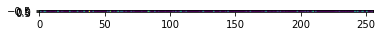

In [24]:
plt.imshow(np.sum(x, axis=0).reshape(1, 256))

/home/archie/anaconda3/envs/hrl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


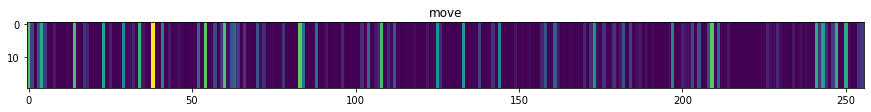

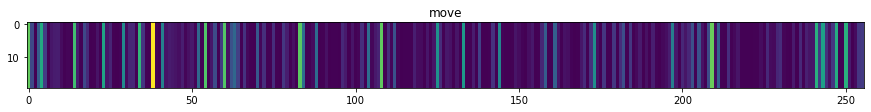

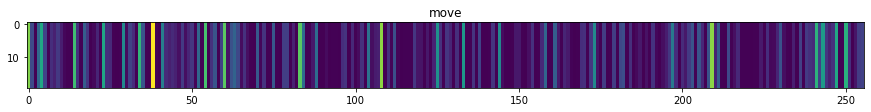

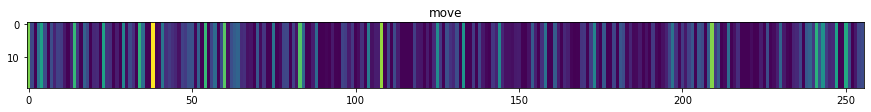

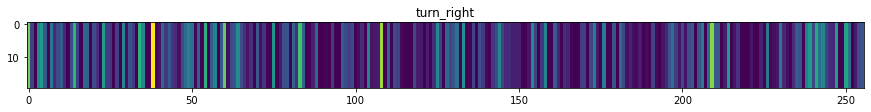

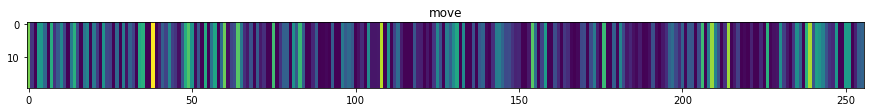

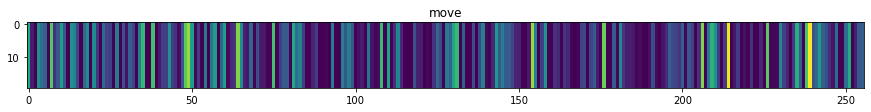

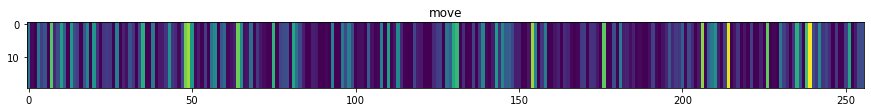

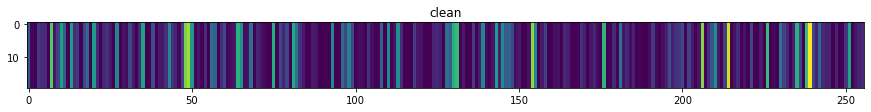

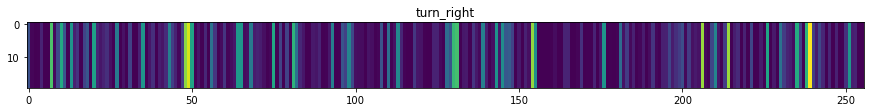

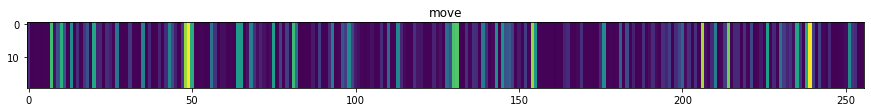

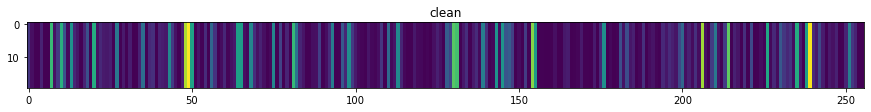

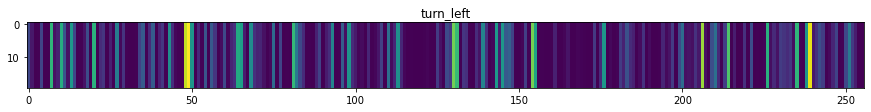

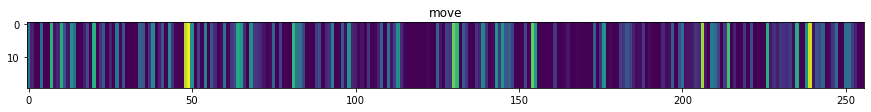

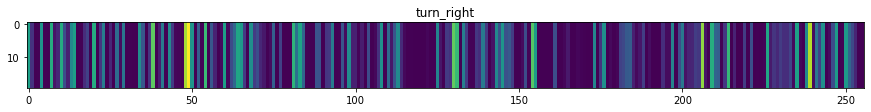

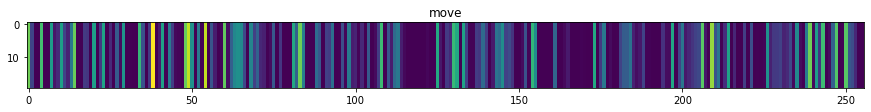

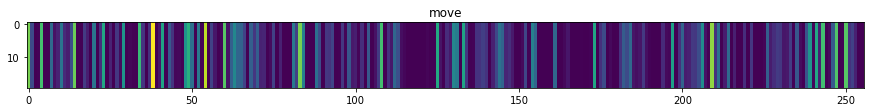

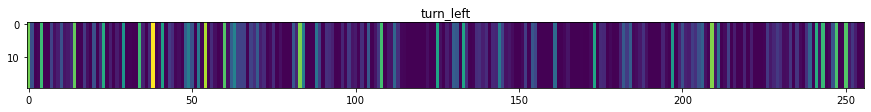

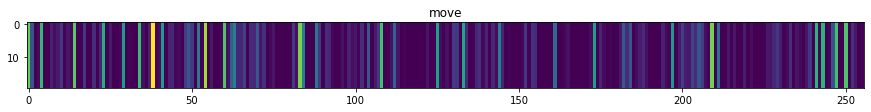

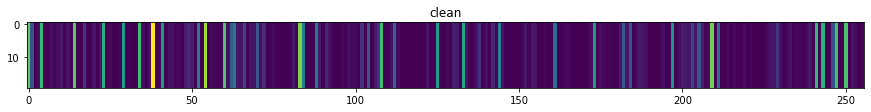

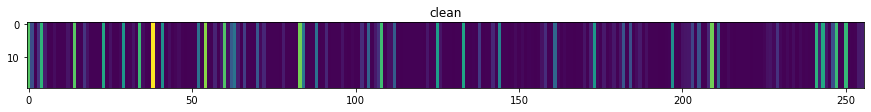

In [38]:
for g in range(len(goal_gen)):
    x = np.array([i.detach().cpu().numpy()[0] for i in goal_gen[g]])
    plt.figure(figsize=(15, 12))
    x = np.sum(x, axis=0).reshape(1, 256)
    q = np.zeros((20, 256))
    for k in range(20):
        q[k, :] = x
    plt.imshow(q);
    plt.title(env.action_meanings[predictions[g]])

In [44]:
def goal_plot(z):
    plt.figure(figsize=(15, 10))
    for i, d in enumerate(z):
        print(d)
        x = np.zeros((10, 256))
        for k in range(10):
            x[k, :] = d
        plt.subplot(i+1, 1, i+1)
    plt.show()

In [45]:
prev = np.zeros(256)
for ix, z in enumerate(zip(goal_gen[:-1], goal_gen[1:])):
    print(f'g{ix}\t<------>\tg{ix+1}\t= ', round(direction(z[0], z[1]), 3), '\t', \
          ' '*5, round(direction(goal_gen[0], z[0]), 3), \
         ' '*5, round(direction(goal_gen[0], z[1])), '-'*3 , env.action_meanings[predictions[ix]])

TypeError: ufunc 'inner1d' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
for ix, g in enumerate(goal_gen):
    f = plt.figure(figsize=(15, 8))
    x = np.zeros((10, 256))
    for i in range(10):
        x[i,:] = g
    ax = plt.subplot(1, 1, 1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.imshow(x)

ValueError: cannot copy sequence with size 10 to array axis with dimension 256

<Figure size 1080x576 with 0 Axes>

In [34]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array(goal_gen)
X_embedded = TSNE(n_components=3).fit_transform(X)
X_embedded.shape

(21, 3)

In [35]:
X_embedded

array([[ 572.12427  ,    1.2303499, -116.44827  ],
       [-139.69695  ,  181.60255  ,    7.2109284],
       [ 327.097    , -146.08894  ,   21.77924  ],
       [ -51.990242 , -227.56412  ,  223.1404   ],
       [ 129.16893  , -209.27495  ,   83.518456 ],
       [ -54.733143 ,  -69.34294  ,   40.93526  ],
       [  17.884546 ,  -32.513443 , -163.18002  ],
       [-479.92493  , -280.5225   , -606.5593   ],
       [-495.84732  ,  -23.951809 ,   94.06345  ],
       [-194.57184  ,  -51.896763 ,  315.8874   ],
       [ 246.32188  ,  -17.772036 , -155.46323  ],
       [  87.56106  ,  248.52934  ,   47.96109  ],
       [ 241.38425  ,   76.08025  ,   85.63769  ],
       [  27.641945 ,  197.63188  , -187.42375  ],
       [-256.9177   ,    2.8402123,  104.63647  ],
       [-176.26761  , -146.8267   , -179.83954  ],
       [  28.844133 ,   62.40897  ,  222.7843   ],
       [ 206.52063  ,  131.63672  , -334.54846  ],
       [-348.7621   ,  -10.271827 , -111.50785  ],
       [ 359.4623   ,  515.7371

In [36]:
X_embedded[:,0], X_embedded[:,1], X_embedded[:,2]

(array([ 572.12427 , -139.69695 ,  327.097   ,  -51.990242,  129.16893 ,
         -54.733143,   17.884546, -479.92493 , -495.84732 , -194.57184 ,
         246.32188 ,   87.56106 ,  241.38425 ,   27.641945, -256.9177  ,
        -176.26761 ,   28.844133,  206.52063 , -348.7621  ,  359.4623  ,
         -58.09763 ], dtype=float32),
 array([   1.2303499,  181.60255  , -146.08894  , -227.56412  ,
        -209.27495  ,  -69.34294  ,  -32.513443 , -280.5225   ,
         -23.951809 ,  -51.896763 ,  -17.772036 ,  248.52934  ,
          76.08025  ,  197.63188  ,    2.8402123, -146.8267   ,
          62.40897  ,  131.63672  ,  -10.271827 ,  515.7371   ,
        -315.5428   ], dtype=float32),
 array([-116.44827  ,    7.2109284,   21.77924  ,  223.1404   ,
          83.518456 ,   40.93526  , -163.18002  , -606.5593   ,
          94.06345  ,  315.8874   , -155.46323  ,   47.96109  ,
          85.63769  , -187.42375  ,  104.63647  , -179.83954  ,
         222.7843   , -334.54846  , -111.50785  , 1003.

In [37]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
# t = np.linspace(0, 10, 50)
# x, y, z = np.cos(t), np.sin(t), t
x = X_embedded[:,0]
y = X_embedded[:,1]
z = X_embedded[:,2]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(size=4,
                                               color=x,                # set color to an array/list of desired values
                                               colorscale='Viridis',   # choose a colorscale
                                               opacity=0.8))])
fig.show()